Bayes Theorem
$$ \Large P(A|B) = \frac{P(B|A)\bullet P(A)}{P(B)}$$

Multinomial Bayes:  
$$ \Large P(y|x_1, x_2, ..., x_n) = \frac{P(y)\prod_{i}^{n}P(x_i|y)}{P(x_1, x_2, ..., x_n)}$$

### Gaussian Naive Bayes algorithm demonstration (Iris Dataset):

In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np

iris = datasets.load_iris()

X = pd.DataFrame(iris.data)
X.columns = iris.feature_names

y = pd.DataFrame(iris.target)
y.columns = ['Target']

df = pd.concat([X, y], axis=1)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [2]:
# check how many observations there are for each flower species
df['Target'].value_counts()

Target
0    50
1    50
2    50
Name: count, dtype: int64

Next, we calculate the mean and standard deviation within a class for each of the features. We'll then use these values to calculate the conditional probability of a particular feature observation for each of the classes.

In [3]:
aggs = df.groupby('Target').agg(['mean', 'std'])
aggs

sepal length (cm)           sepal width (cm)            \
                    mean       std             mean       std   
Target                                                          
0                  5.006  0.352490            3.428  0.379064   
1                  5.936  0.516171            2.770  0.313798   
2                  6.588  0.635880            2.974  0.322497   

       petal length (cm)           petal width (cm)            
                    mean       std             mean       std  
Target                                                         
0                  1.462  0.173664            0.246  0.105386  
1                  4.260  0.469911            1.326  0.197753  
2                  5.552  0.551895            2.026  0.274650

#### Calculate conditional probability point estimates

Take another look at how to implement point estimates for the conditional probabilities of a feature for a given class. To do this, you'll simply use the PDF of the normal distribution. (Again, there can be some objection to this method as the probability of a specific point for a continuous distribution is 0. Some statisticians bin the continuous distribution into a discrete approximation to remedy this, but doing so requires additional work and the width of these bins is an arbitrary value which will potentially impact results.)

$$ \Large P(x_i|y) = \frac{1}{\sqrt{2 \pi \sigma_i^2}}e^{\frac{-(x-\mu_i)^2}{2\sigma_i^2}}$$

In [4]:
from scipy import stats

def p_x_given_class(obs_row, feature, class_):
    mu = aggs[feature]['mean'][class_]
    std = aggs[feature]['std'][class_]
    
    # A single observation
    obs = df.iloc[obs_row][feature] 
    
    p_x_given_y = stats.norm.pdf(obs, loc=mu, scale=std)
    return p_x_given_y

# Notice how this is not a true probability; you can get values > 1
p_x_given_class(0, 'petal length (cm)', 0) 

2.1553774365786813

In [5]:
#Multinomial Bayes
row = 100
c_probs = []
for c in range(3):
    # Initialize probability to relative probability of class 
    p = len(df[df['Target'] == c])/len(df) 
    for feature in X.columns:
        p *= p_x_given_class(row, feature, c) 
        # Update the probability using the point estimate for each feature
        c_probs.append(p)

c_probs

[0.0004469582872647601,
 0.0004443285586702692,
 5.436807559640814e-152,
 9.529514999027503e-251,
 0.20091323410933296,
 0.06135077392562653,
 5.488088968636931e-05,
 2.4601490099164823e-12,
 0.1887425821931874,
 0.1400761027216959,
 0.07283357796352255,
 0.02386104253740266]

#### Calculating class probabilities for observations

While you haven't even attempted to calculate the denominator for the original equation,  

$$P(y|x_1,x_2,...x_n) = \frac{P(y)\prod_{i}^{n}P(x_i|y)}{P(x_1,x_2,...x_n)}$$ 

you don't really have to.  

That is, the probability $P(x_1, x_2, ..., x_n)$ is the probability of the given observation across all classes; it is not a function of class at all. As such, it will be a constant across all of these posterior class probabilities. Since you are simply interested in the most likely class for each observation, you can simply pick the class with the largest numerator. With that, let's adapt the code snippet above to create a function which predicts a class for a given row of data.

In [6]:
def predict_class(row):
    c_probs = []
    for c in range(3):
        # Initialize probability to relative probability of class
        p = len(df[df['Target'] == c])/len(df) 
        for feature in X.columns:
            p *= p_x_given_class(row, feature, c)
        c_probs.append(p)
    return np.argmax(c_probs)

In [7]:
#Let's also take an example row to test this new function
row = 0
df.iloc[row]

sepal length (cm)    5.1
sepal width (cm)     3.5
petal length (cm)    1.4
petal width (cm)     0.2
Target               0.0
Name: 0, dtype: float64

In [8]:
predict_class(row)

0

Nice! It appears that this `predict_class()` function has correctly predicted the class for this first row! Now it's time to take a look at how accurate this function is across the entire dataset!

In order to determine the overall accuracy of your newly minted Gaussian Naive Bayes classifier, you'll need to generate predictions for all of the rows in the dataset. From there, you can then compare these predictions to the actual class values stored in the 'Target' column. Take a look:

In [9]:
df['Predictions'] =  [predict_class(row) for row in df.index]
df['Correct?'] = df['Target'] == df['Predictions']
df['Correct?'].value_counts(normalize=True)

Correct?
True     0.96
False    0.04
Name: proportion, dtype: float64

Nicely done! You're well on your way to using Bayesian statistics in the context of machine learning! In this lesson, you saw how to adapt Bayes theorem along with your knowledge of the normal distribution to create a machine learning classifier known as Gaussian Naive Bayes.

## Implementing Gaussian Naive Bayes algorithm (Hearts-Disease Dataset)

In [10]:
# Load the dataset
import pandas as pd

df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.708333,1.0,1.000000,0.481132,0.244292,1.0,0.0,0.603053,0.0,0.370968,0.0,0.0,0.333333,1.0
1,0.166667,1.0,0.666667,0.339623,0.283105,0.0,0.5,0.885496,0.0,0.564516,0.0,0.0,0.666667,1.0
2,0.250000,0.0,0.333333,0.339623,0.178082,0.0,0.0,0.770992,0.0,0.225806,1.0,0.0,0.666667,1.0
3,0.562500,1.0,0.333333,0.245283,0.251142,0.0,0.5,0.816794,0.0,0.129032,1.0,0.0,0.666667,1.0
4,0.583333,0.0,0.000000,0.245283,0.520548,0.0,0.5,0.702290,1.0,0.096774,1.0,0.0,0.666667,1.0


AttributeError: 'SubplotSpec' object has no attribute 'is_first_col'

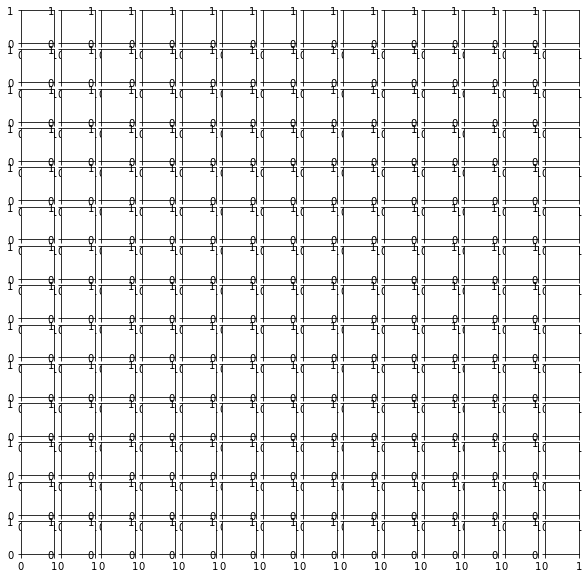

In [11]:
# Optional but always recommended; briefly explore your dataset
pd.plotting.scatter_matrix(df, figsize=(10,10)); 

In [12]:
# Optional but always recommended; briefly explore your dataset
df['target'].value_counts() 

target
1.0    165
0.0    138
Name: count, dtype: int64

In [13]:
# Your code here
X = df[[col for col in df.columns if col != 'target']]
y = df['target']

In [14]:
# Perform a train-test split 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22)

In [15]:
# Calculate the mean and standard deviation for each feature within each class for the training set
train = pd.concat([X_train, y_train], axis=1)
aggs = train.groupby('target').agg(['mean', 'std'])
aggs

age                 sex                  cp            trestbps  \
            mean       std      mean       std      mean       std      mean   
target                                                                         
0.0     0.589199  0.166856  0.796117  0.404853  0.155340  0.305418  0.378000   
1.0     0.485887  0.208241  0.564516  0.497832  0.475806  0.324193  0.331482   

                      chol            ...     exang             oldpeak  \
             std      mean       std  ...      mean       std      mean   
target                                ...                                 
0.0     0.178486  0.286629  0.119501  ...  0.543689  0.500523  0.258221   
1.0     0.156504  0.261452  0.106583  ...  0.161290  0.369291  0.095604   

                     slope                  ca                thal            
             std      mean       std      mean       std      mean       std  
target                                                                        
0.0     0.211331  0.592233  0.277838  0.303398  0.256414  0.860841  0.200893  
1.0     0.120894  0.790323  0.306414  0.088710  0.204605  0.690860  0.148302  

[2 rows x 26 columns]

In [16]:
# Your code here
from scipy import stats
def p_x_given_class(obs_row, feature, class_):
    mu = aggs[feature]['mean'][class_]
    std = aggs[feature]['std'][class_]
    
    # Observation
    obs = obs_row[feature] 
    
    p_x_given_y = stats.norm.pdf(obs, loc=mu, scale=std)
    return p_x_given_y
p_x_given_class(X_train.iloc[0], X.columns[0], 0)

1.6817730299440616

In [17]:
import numpy as np
def predict_class(obs_row):
    c_probs = []
    for c in range(2):
        # Initialize probability to relative probability of class
        p = len(y_train[y_train == c])/len(y_train) 
        for feature in X.columns:
            p *= p_x_given_class(obs_row, feature, c)
        c_probs.append(p)
    return np.argmax(c_probs)

In [18]:
predict_class(X_train.iloc[0])

0

In [19]:
#Applying prediction function to train and test sets
y_hat_train = [predict_class(X_train.iloc[idx]) for idx in range(len(X_train))]
y_hat_test = [predict_class(X_test.iloc[idx]) for idx in range(len(X_test))]

In [20]:
#Calculate train and test accuracy
residuals_train = y_hat_train == y_train
acc_train = residuals_train.sum()/len(residuals_train)

residuals_test = y_hat_test == y_test
acc_test = residuals_test.sum()/len(residuals_test)
print('Training Accuracy: {}\tTesting Accuracy: {}'.format(acc_train, acc_test))

Training Accuracy: 0.8502202643171806	Testing Accuracy: 0.8289473684210527


In [21]:
#Rewriting conditional probability function
def p_band_x_given_class(obs_row, feature, c, range_width_std):
    """obs_row is the observation in question 
    feature is the feature of the observation row for which you are calculating a conditional probability
    c is the class flag for the conditional probability
    range_width_std is the range in standard deviations of the feature variable to calculate the integral under the PDF curve for"""
    
    mu = aggs[feature]['mean'][c]
    std = aggs[feature]['std'][c]
    
    # observation
    obs = obs_row[feature] 
    interval_min = obs - range_width_std*std/2
    interval_max = obs + range_width_std*std/2
    
    cdf_min = stats.norm.cdf(interval_min, loc=mu, scale=std)
    cdf_max = stats.norm.cdf(interval_max, loc=mu, scale=std)
    p_x_given_y = cdf_max - cdf_min
    return p_x_given_y

In [22]:
#Updating prediction function
def predict_class(obs_row, how='bands', range_width_std=.25):
    c_probs = []
    for c in range(2):
        # Initialize probability to relative probability of class
        p = len(y_train[y_train == c])/len(y_train) 
        for feature in X.columns:
            if how == 'bands':
                p *= p_band_x_given_class(obs_row, feature, c, range_width_std=range_width_std)
            else:
                p *= p_x_given_class(obs_row, feature, c)
        c_probs.append(p)
    return np.argmax(c_probs)

Finally, write a `for` loop to measure the impact of varying range-widths on the classifier's test and train accuracy. Iterate over various range-widths from 0.1 standard deviations to 2 standard deviations. For each of these, store the associated test and train accuracies. Finally, plot these on a graph. The x-axis should be the associated range-width (expressed in standard deviations; each feature will have a unique width applicable to the specific scale). The y-axis will be the associated accuracy. Be sure to include a legend for train accuracy versus test accuracy.

_Note:_ ⏰ _Expect your code to take over two minutes to run._

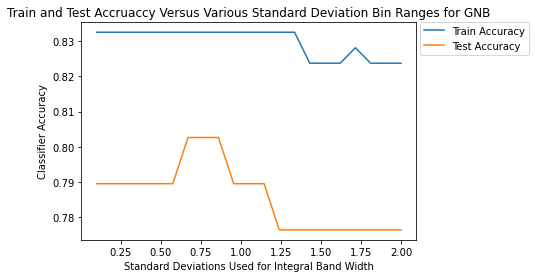

In [23]:
# Your code here
import matplotlib.pyplot as plt
%matplotlib inline
train_accs = []
test_accs = []
range_stds = np.linspace(0.1, 2, num=21)
for range_std in range_stds:    
    y_hat_train = [predict_class(X_train.iloc[idx], range_width_std=range_std) for idx in range(len(X_train))]
    y_hat_test = [predict_class(X_test.iloc[idx], range_width_std=range_std) for idx in range(len(X_test))]
    
    residuals_train = y_hat_train == y_train
    acc_train = residuals_train.sum()/len(residuals_train)

    residuals_test = y_hat_test == y_test
    acc_test = residuals_test.sum()/len(residuals_test)
    
    train_accs.append(acc_train)
    test_accs.append(acc_test)
plt.plot(range_stds, train_accs, label='Train Accuracy')
plt.plot(range_stds, test_accs, label='Test Accuracy')
plt.title('Train and Test Accruaccy Versus Various Standard Deviation Bin Ranges for GNB')
plt.ylabel('Classifier Accuracy')
plt.xlabel('Standard Deviations Used for Integral Band Width')
plt.legend(loc=(1.01,.85));

> **Not a wild difference from our point estimates obtained by using points from the PDF itself, but there is some impact. Interestingly, these graphs will differ substantially in shape depending on the initial train-test split used. The recommendation would be to use the point estimates from the PDF itself, or a modest band-width size.**

In [24]:
#Plotting PDFs and Probability Integrals
temp = df[df['target'] == 1]['trestbps']
aggs = temp.agg(['mean', 'std'])
aggs

mean    0.333047
std     0.152544
Name: trestbps, dtype: float64

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sns
import scipy.stats as stats
sns.set_style('white')

Probability of Blood Pressure Falling withing Range for the Given Class: 0.0


Text(0.5, 0, 'Resting Blood Pressure')

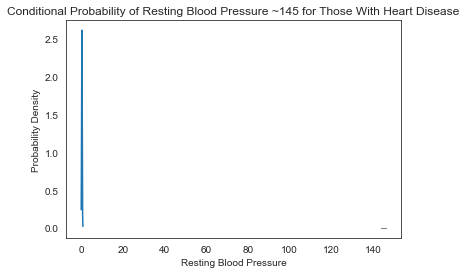

In [26]:
x = np.linspace(temp.min(), temp.max(), num=10**3)
pdf = stats.norm.pdf(x, loc=aggs['mean'], scale=aggs['std'])
xi = 145
width = 2
xi_lower = xi - width/2
xi_upper = xi + width/2

fig, ax = plt.subplots()

plt.plot(x, pdf)

# Make the shaded region
ix = np.linspace(xi_lower, xi_upper)
iy = stats.norm.pdf(ix, loc=aggs['mean'], scale=aggs['std'])
verts = [(xi_lower, 0), *zip(ix, iy), (xi_upper, 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
ax.add_patch(poly);

plt.plot((145, 145), (0, stats.norm.pdf(145, loc=aggs['mean'], scale=aggs['std'])), linestyle='dotted')
p_area = stats.norm.cdf(xi_upper, loc=aggs['mean'], scale=aggs['std']) - stats.norm.cdf(xi_lower, loc=aggs['mean'], scale=aggs['std'])
print('Probability of Blood Pressure Falling withing Range for the Given Class: {}'.format(p_area))
plt.title('Conditional Probability of Resting Blood Pressure ~145 for Those With Heart Disease')
plt.ylabel('Probability Density')
plt.xlabel('Resting Blood Pressure')

> Comment: See https://matplotlib.org/gallery/showcase/integral.html for further details on plotting shaded integral areas under curves.

## Document Classification with Naive Bayes
We shall investigate another implementation of the Bayesian framework in order to classify YouTube videos into the appropriate topic. 

In [27]:
#Load Dataset
import pandas as pd
df = pd.read_csv('raw_text.csv')
df.head()

,text,label
0,The following content is\nprovided under a Cre...,Calculus
1,"In this sequence of segments,\nwe review some ...",Probability
2,The following content is\nprovided under a Cre...,CS
3,The following\ncontent is provided under a Cre...,Algorithms
4,The following\ncontent is provided under a Cre...,Algorithms


In [28]:
df['label'].value_counts()

label
Linear Algebra     152
Probability        124
CS                 104
Diff. Eq.           93
Algorithms          81
Statistics          79
Calculus            70
Data Structures     62
AI                  48
Math for Eng.       28
NLP                 19
Name: count, dtype: int64

In [29]:
#subsetting to two specific classes
df2 = df[df['label'].isin(['Algorithms', 'Statistics'])]
df2['label'].value_counts()

label
Algorithms    81
Statistics    79
Name: count, dtype: int64

In [30]:
p_classes = dict(df2['label'].value_counts(normalize=True))
p_classes

{'Algorithms': 0.50625, 'Statistics': 0.49375}

In [31]:
df2.iloc[0]

text     The following\ncontent is provided under a Cre...
label                                           Algorithms
Name: 3, dtype: object

In [32]:
#Perform train-test split
from sklearn.model_selection import train_test_split
X = df2['text']
y = df2['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)
train_df = pd.concat([X_train, y_train], axis=1) 
test_df = pd.concat([X_test, y_test], axis=1)

In [33]:
# Creating word frequency dictionary for each class
# Will be a nested dictionary of class_i : {word1:freq, word2:freq..., wordn:freq},.... class_m : {}
class_word_freq = {} 
classes = train_df['label'].unique()
for class_ in classes:
    temp_df = train_df[train_df.label == class_]
    bag = {}
    for row in temp_df.index:
        doc = temp_df['text'][row]
        for word in doc.split():
            bag[word] = bag.get(word, 0) + 1
    class_word_freq[class_] = bag

In [34]:
#Count the total corpus words
vocabulary = set()
for text in train_df['text']:
    for word in text.split():
        vocabulary.add(word)
V = len(vocabulary)
V

23977

In [35]:
#Bag of words function
def bag_it(doc):
    bag = {}
    for word in doc.split():
        bag[word] = bag.get(word, 0) + 1
    return bag

In [36]:
#Implementing Naive Bayes
import numpy as np
def classify_doc(doc, class_word_freq, p_classes, V, return_posteriors=False):
    bag = bag_it(doc)
    classes = []
    posteriors = []
    for class_ in class_word_freq.keys():
        p = p_classes[class_]
        for word in bag.keys():
            num = bag[word]+1
            denom = class_word_freq[class_].get(word, 0) + V
            p *= (num/denom)
        classes.append(class_)
        posteriors.append(p)
    if return_posteriors:
        print(posteriors)
    return classes[np.argmax(posteriors)]

In [37]:
classify_doc(train_df.iloc[0]['text'], class_word_freq, p_classes, V, return_posteriors=True)

[0.0, 0.0]


'Algorithms'

#### Avoid underflow

As you can see from the output above, repeatedly multiplying small probabilities can lead to underflow; rounding to zero due to numerical approximation limitations. As such, a common alternative is to add the logarithms of the probabilities as opposed to multiplying the raw probabilities themselves. If this is alien to you, it might be worth reviewing some algebra rules of exponents and logarithms briefly:  

$ e^x \cdot e^y = e^{x+y}$  
$ log_{e}(e)=1 $  
$ e^{log(x)} = x$  

With that, here's an updated version of the function using log probabilities to avoid underflow:

In [38]:
def classify_doc(doc, class_word_freq, p_classes, V, return_posteriors=False):
    bag = bag_it(doc)
    classes = []
    posteriors = []
    for class_ in class_word_freq.keys():
        p = np.log(p_classes[class_])
        for word in bag.keys():
            num = bag[word]+1
            denom = class_word_freq[class_].get(word, 0) + V
            p += np.log(num/denom)
        classes.append(class_)
        posteriors.append(p)
    if return_posteriors:
        print(posteriors)
    return classes[np.argmax(posteriors)]

In [39]:
classify_doc(train_df.iloc[0]['text'], class_word_freq, p_classes, V, return_posteriors=True)

[-5578.267536771343, -5577.213285866603]


'Statistics'

In [40]:
classify_doc(train_df.iloc[10]['text'], class_word_freq, p_classes, V, return_posteriors=True)

[-2572.1544445158343, -2571.311308656896]


'Statistics'

In [41]:
classify_doc(train_df.iloc[12]['text'], class_word_freq, p_classes, V, return_posteriors=True)

[-4602.602622507951, -4601.755644621728]


'Statistics'

In [42]:
y_hat_train = X_train.map(lambda x: classify_doc(x, class_word_freq, p_classes, V))
residuals = y_train == y_hat_train
residuals.value_counts(normalize=True)

False    0.508333
True     0.491667
Name: proportion, dtype: float64

> As you can see, this algorithm leaves a lot to be desired. A measly 49% accuracy is nothing to write home about. (In fact, it's slightly worse than random guessing!) In practice, substantial additional preprocessing including removing stop words and using stemming or lemmatisation would be required. Even then, Naive Bayes might still not be the optimal algorithm. Nonetheless, it is a worthwhile exercise and a comprehendible algorithm. 

## Document Classification with Naive Bayes (SMS Spam Collection Dataset)

In [44]:
#Import dataset
import pandas as pd
df = pd.read_csv('SMSSpamCollection.txt', sep='\t', names=['label', 'text'])
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


To help our algorithm perform more accurately, we shall subset the dataset so that the two classes are of equal size. To do this, keep all of the instances of the minority class (spam) and subset examples of the majority class (ham) to an equal number of examples.

In [45]:
#Accounting for class imbalance
minority = df[df['label'] == 'spam']
undersampled_majority = df[df['label'] == 'ham'].sample(n=len(minority))
df2 = pd.concat([minority, undersampled_majority])
df2.label.value_counts()

label
spam    747
ham     747
Name: count, dtype: int64

In [46]:
p_classes = dict(df2['label'].value_counts(normalize=True))
p_classes

{'spam': 0.5, 'ham': 0.5}

In [47]:
df2.iloc[0]

label                                                 spam
text     Free entry in 2 a wkly comp to win FA Cup fina...
Name: 2, dtype: object

In [48]:
#implementing train-test split on the dataset:
from sklearn.model_selection import train_test_split
X = df2['text']
y = df2['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)
train_df = pd.concat([X_train, y_train], axis=1) 
test_df = pd.concat([X_test, y_test], axis=1)

In [49]:
#Creating word frequency dictionary for each class:
# Will be a nested dictionary of class_i : {word1:freq, word2:freq..., wordn:freq},.... class_m : {}
class_word_freq = {} 
classes = train_df['label'].unique()
for class_ in classes:
    temp_df = train_df[train_df['label'] == class_]
    bag = {}
    for row in temp_df.index:
        doc = temp_df['text'][row]
        for word in doc.split():
            bag[word] = bag.get(word, 0) + 1
    class_word_freq[class_] = bag

In [50]:
#Calculate V, the total number of words in the corpus:
vocabulary = set()
for text in train_df['text']:
    for word in text.split():
        vocabulary.add(word)
V = len(vocabulary)
V

5880

In [51]:
#Creating bag of words function
def bag_it(doc):
    bag = {}
    for word in doc.split():
        bag[word] = bag.get(word, 0) + 1
    return bag

Now, implement a master function to build a naive Bayes classifier. Be sure to use the logarithmic probabilities to avoid underflow.

In [52]:
def classify_doc(doc, class_word_freq, p_classes, V, return_posteriors=False):
    bag = bag_it(doc)
    classes = []
    posteriors = []
    for class_ in class_word_freq.keys():
        p = np.log(p_classes[class_])
        for word in bag.keys():
            num = bag[word]+1
            denom = class_word_freq[class_].get(word, 0) + V
            p += np.log(num/denom)
        classes.append(class_)
        posteriors.append(p)
    if return_posteriors:
        print(posteriors)
    return classes[np.argmax(posteriors)]

### Test your classifier

Finally, test your classifier and measure its accuracy. Don't be perturbed if your results are sub-par; industry use cases would require substantial additional preprocessing before implementing the algorithm in practice.

In [53]:
import numpy as np

y_hat_train = X_train.map(lambda x: classify_doc(x, class_word_freq, p_classes, V))
residuals = y_train == y_hat_train
residuals.value_counts(normalize=True)

False    0.758036
True     0.241964
Name: proportion, dtype: float64